In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [4]:
import seaborn as sns
sns.set(color_codes=True)

In [5]:
colors = [
    "#FE2400",
    "#EC2127",
    "#D21E4E",
    "#B21D72",
    "#951E93",
    "#7421B1",
    "#5023D0",
    "#3025EA",
    "#082EFD",
    "#1147CE",
    "#247395",
    "#389D51",
    "#49C900",
    "#81D503",
    "#AFE400",
    "#DAF201",
    "#FFFF01",
    "#FEE600",
    "#FECD02",
    "#FEAF07",
    "#FF9400",
    "#FE7701",
    "#FD5800",
    "#FF3900",
]

In [45]:
targetDir = "../data/output/d5/Result/"
curveDir = "../data/output/d5/CurveRadius/"
tollgateDir = "../data/output/d5/DistTollgate/"
roadTypeDir = "../data/output/d5/RoadType/"

In [7]:
df1 = pd.read_csv(curveDir + "result.csv")
df1.columns = [["id", "rapid", "middle", "gentle", "straight"]]
df2 = pd.read_csv(tollgateDir + "result.csv")
df2.columns = [["id", "t", "f"]]
df3 = pd.read_csv(roadTypeDir + "result.csv")
df3.columns = [["id", "prefectual", "principal", "public", "others", "interCity", "toll", "national"]]

In [8]:
df = pd.merge(pd.merge(df1, df2), df3)
gridSize = len(df)

In [9]:
features = ["rapid", "middle", "gentle", "straight", "t", "f", "prefectual", "principal", "public", "others", "interCity", "toll", "national"]

In [10]:
valids = df['t'] + df['f'] > 0
mf = df[df['t'] + df['f'] > 0]
mf = mf[features]
mf.columns = features

In [11]:
# RoadTypes = ["interCity", "city", "toll", "national", "prefectual", "principal", "public", "others"]
# CurveRadiuses = {"rapid": "30-100", "middle": "100-150", "gentle": "150-200", "straight": "200-"}
# DistTollgates = {"t": "1-500", "f": "0 or 500-"}

In [12]:
mf.describe()

,rapid,middle,gentle,straight,t,f,prefectual,principal,public,others,interCity,toll,national
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.459770,0.693487,0.643678,6.252874,0.068966,60.226054,0.643678,2.413793,1.620690,0.145594,0.781609,0.371648,2.490421
std,3.023515,2.998383,1.751771,8.245584,0.584277,63.041612,3.678347,6.074319,5.236502,2.352141,1.627352,2.565264,7.338315
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,3.000000,0.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,7.000000,0.000000,81.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,40.000000,32.000000,15.000000,51.000000,6.000000,347.000000,33.000000,35.000000,34.000000,38.000000,12.000000,38.000000,60.000000


In [27]:
bf = mf.copy()

In [28]:
bf["tollgateT"] = (bf["t"] > 0).astype(int)
bf["tollgateF"] = (bf["f"] > 0).astype(int)
bf = bf[["rapid", "middle", "gentle", "straight", "prefectual", "principal", "public", "others", "interCity", "toll", "national", "tollgateT", "tollgateF"]]

In [29]:
roadTypes = ["interCity", "toll", "national", "prefectual", "principal", "public", "others"]
for key in roadTypes:
    bf[key] = (bf[key] > 0).astype(int)

In [30]:
curves = ["rapid", "middle", "gentle", "straight"]
bf["sumCurve"] = bf["rapid"] + bf["middle"] + bf["gentle"] + bf["straight"]
for col in curves:
    bf[col] = bf[col] / bf["sumCurve"]
    
bf = bf.fillna(0)
bf = bf[["rapid", "middle", "gentle", "straight", "prefectual", "principal", "public", "others", "interCity", "toll", "national", "tollgateT", "tollgateF"]]

In [31]:
bf.describe()

,rapid,middle,gentle,straight,prefectual,principal,public,others,interCity,toll,national,tollgateT,tollgateF
count,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000,261.000000
mean,0.036484,0.053412,0.071291,0.785173,0.049808,0.237548,0.130268,0.003831,0.275862,0.057471,0.245211,0.015326,0.996169
std,0.149113,0.150056,0.174347,0.347590,0.217967,0.426398,0.337245,0.061898,0.447806,0.233188,0.431039,0.123081,0.061898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.642857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
bf = bf[["rapid", "middle", "gentle", "prefectual", "principal", "public", "others", "interCity", "toll", "tollgateT"]]

# VBGMM

In [94]:
components = 10
weight_concentration_prior = 0.0001
cov_type = 'full'
cov_prior = np.identity(len(features)-3)

In [95]:
sd = 1
np.random.seed(sd)
random.seed(sd)

In [96]:
vb = BayesianGaussianMixture(
    n_components=components,
    covariance_type=cov_type,
    covariance_prior=cov_prior,
    weight_concentration_prior = weight_concentration_prior,
).fit(bf)
print "class size:      ", len(set(vb.predict(bf)))
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

class size:       8
classes:           set([1, 2, 3, 4, 5, 6, 7, 8])
lower bound:  3653.79805449


In [97]:
ws = ["%02f" % w for w in vb.weights_]

In [103]:
ref = pd.DataFrame(vb.means_)
ref.columns = ["rapid", "middle", "gentle", "prefectual", "principal", "public", "others", "interCity", "toll", "tollgateT"]
ref["straight"] = 1 - (ref["rapid"] + ref["middle"] + ref["gentle"])
ref["national"] = 1 - (ref["prefectual"] + ref["principal"] + ref["public"] + ref["others"] + ref["interCity"] + ref["toll"])
ref["tollgateF"] = 1 - ref["tollgateT"]
ref["weight"] = ws
ref = ref[["rapid", "middle", "gentle", "straight", "prefectual", "principal", "public", "others", "interCity", "toll", "national", "tollgateT", "tollgateF", "weight"]]
ref.sort_values("weight", ascending=False)

,rapid,middle,gentle,straight,prefectual,principal,public,others,interCity,toll,national,tollgateT,tollgateF,weight
6,0.008153,0.047612,0.098046,0.846188,0.000664,0.003167,0.001737,0.000051,0.003678,0.000766,0.989936,0.000204,0.999796,0.272587
2,0.030601,0.017323,0.006381,0.945695,0.000692,0.003299,0.001809,0.000053,0.989942,0.000798,0.003406,0.014040,0.985960,0.272413
1,0.010665,0.066632,0.049896,0.872807,0.000874,0.986624,0.002285,0.000067,0.004840,0.001008,0.004302,0.000269,0.999731,0.216727
3,0.058453,0.096623,0.124919,0.720004,0.001509,0.007198,0.973644,0.030419,0.008359,0.001742,-0.022872,0.000464,0.999536,0.123939
4,0.177531,0.052945,0.040572,0.728952,0.004142,0.019755,0.010832,0.000319,0.022943,0.921619,0.020391,0.003528,0.996472,0.044729
5,0.061903,0.093535,0.186512,0.658050,0.905044,0.024881,0.212837,0.000383,0.027567,0.005742,-0.176454,0.001532,0.998468,0.036822
7,0.007354,0.097420,0.364896,0.530330,0.809588,0.846711,0.026102,0.000768,0.055298,0.011517,-0.749982,0.003081,0.996919,0.016118
8,0.335711,0.101241,0.044605,0.518444,0.010007,0.449446,0.026167,0.000770,0.257203,0.809743,-0.553334,0.601130,0.398870,0.012848
0,0.036483,0.053419,0.071292,0.838807,0.049808,0.237545,0.130266,0.003831,0.275872,0.057471,0.245207,0.015332,0.984668,0.003817
9,0.036484,0.053412,0.071291,0.838813,0.049808,0.237548,0.130268,0.003831,0.275862,0.057471,0.245211,0.015326,0.984674,0.000000


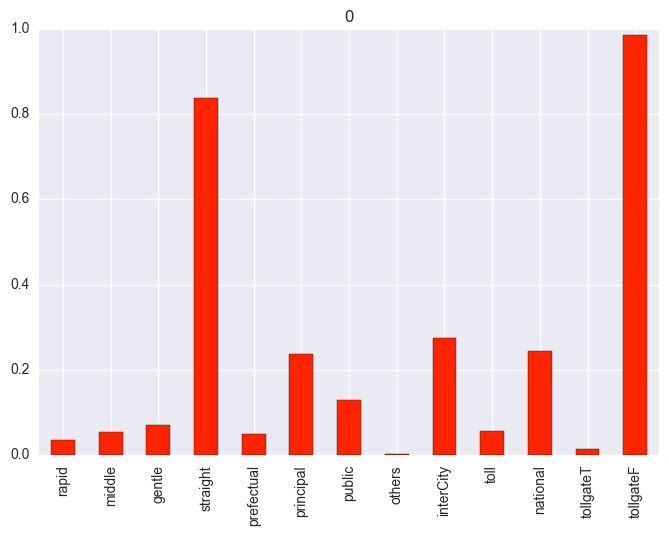

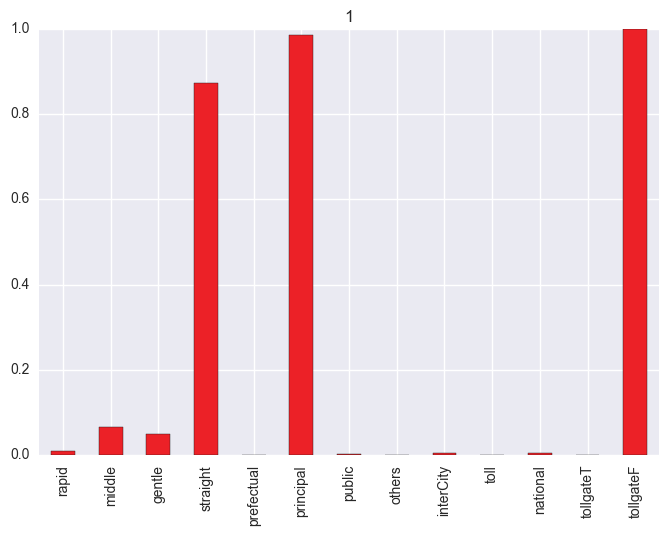

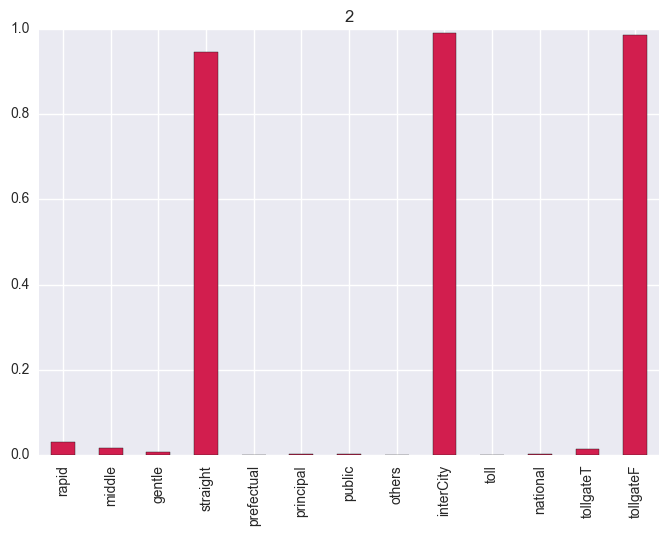

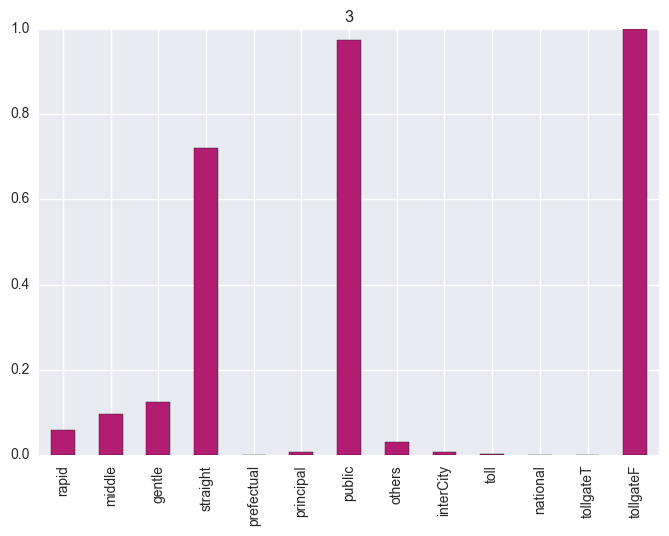

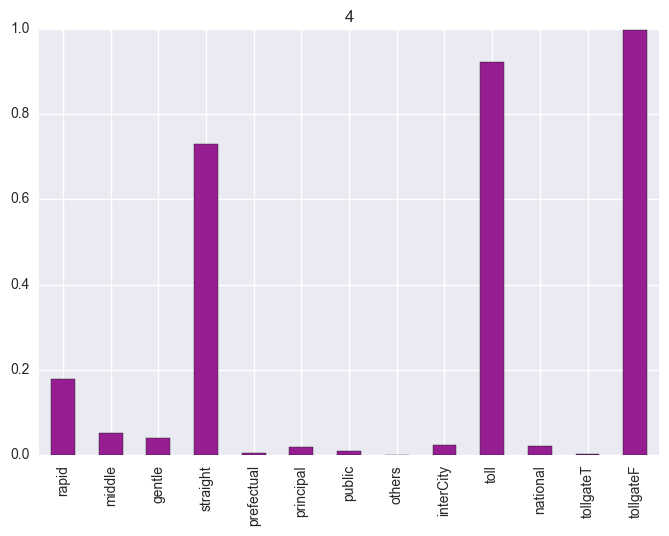

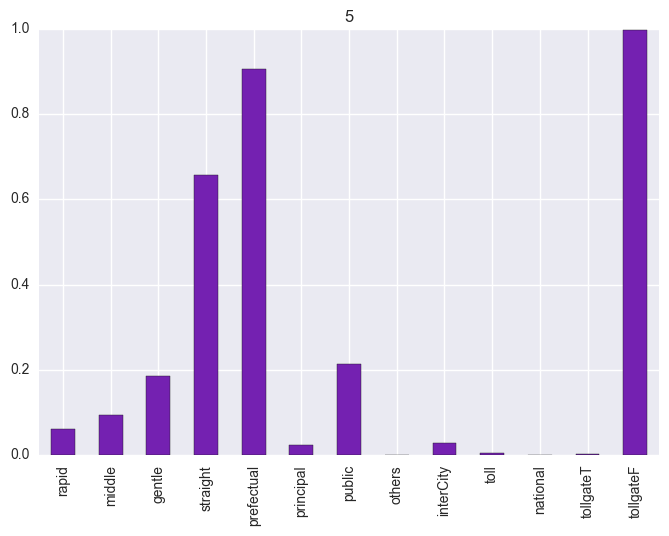

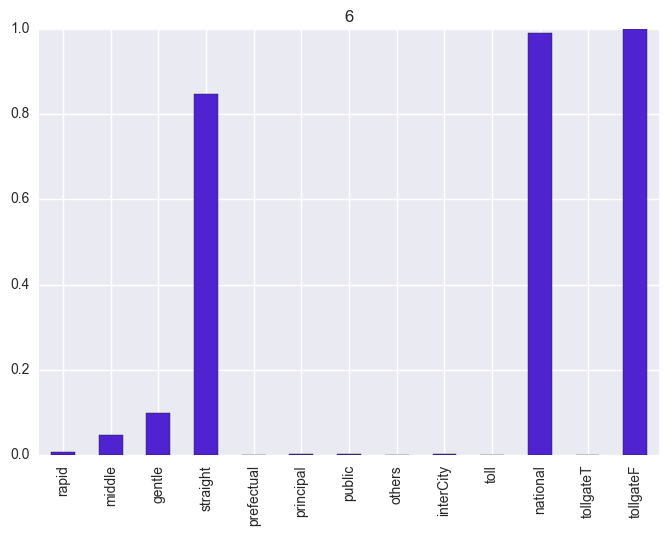

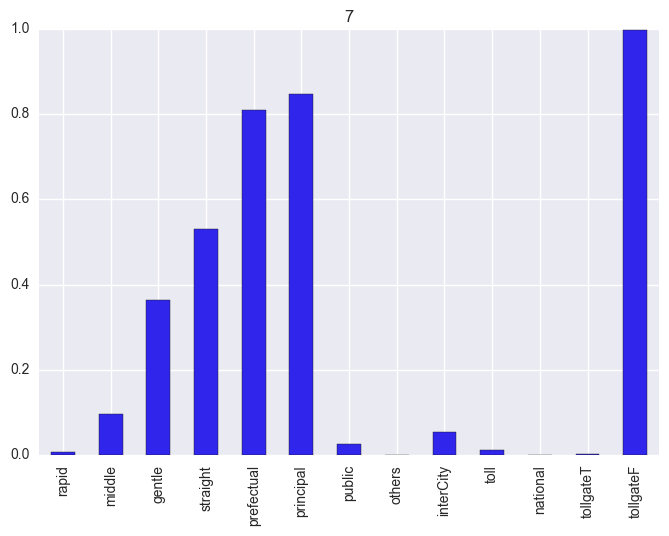

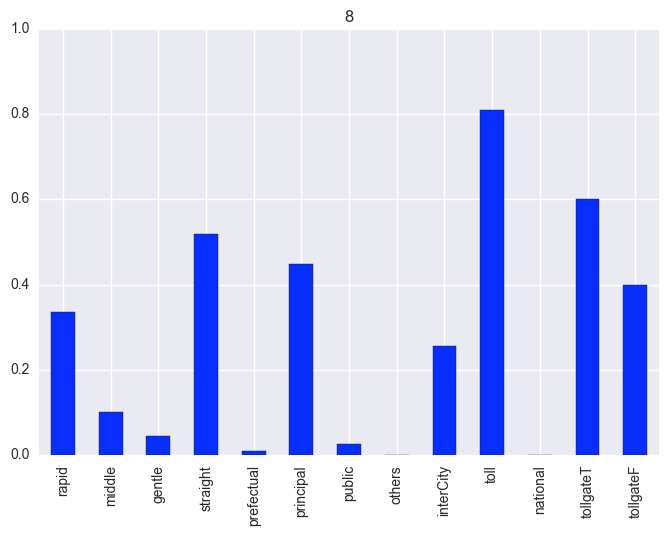

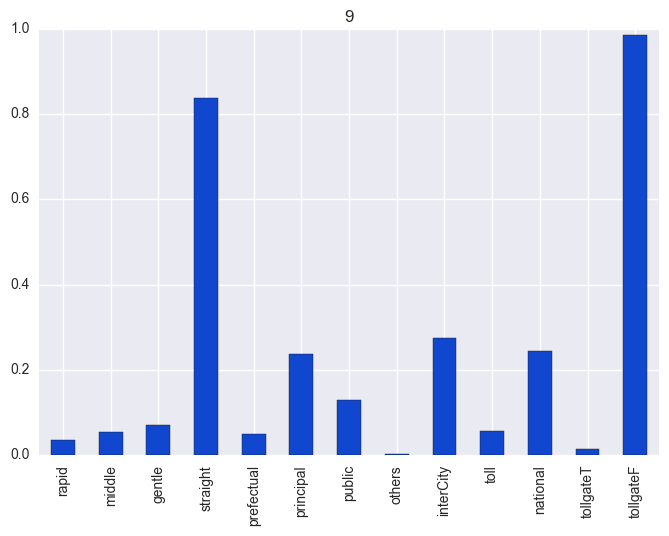

In [104]:
indices = ref.sort_values("weight", ascending=False).index.tolist()

ref = ref[["rapid", "middle", "gentle", "straight", "prefectual", "principal", "public", "others", "interCity", "toll", "national", "tollgateT", "tollgateF"]]
for i in range(components):
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.ylim(0, 1)
    plt.title(i)
    plt.show()

In [105]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")